# proxy finder
Goal: We have a dataset that includes one expensive item. We'd like to find a proxy for that item in another datset that doesn't have an explicit measurement for that item. A proxy is a single variable that is able to predict the item.

Solution: Use ML to create a linear model to predict the item in the first dataset as a linear combination of other variables that are explicitly measured in both datasets. The existing variable that is most similar to the approximation of the item is the best-fitting proxy.

Optional Orthogonalization: Optionally, input variables that we don't want the proxy to be correlated with. The algorithm will weight orthogonalization evenly (unless 'orthogonalization_weight' is specified) with correlation to the item approximation.


In [1]:
import numpy as np
import pandas as pd
import sys
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
def proxy_finder_validate(item, candidates, df1, df2, predictors, orthogonal_vars):

    # validate proxies and st item
    assert item in df1.columns, f'AssertionError: item {item} not in df1.columns'

    assert predictors, f'AssertionError: missing predictors'
    
    for c in predictors:
        assert c in df1.columns, f'AssertionError: predictor {c} not in df1.columns'
        assert c in df2.columns, f'AssertionError: predictor {c} not in df2.columns' # only because we need same variable in second dataset        
    
    for c in candidates:
        assert c in df2.columns, f'AssertionError: candidate {c} not in df2.columns'
        
    if (orthogonal_vars != None):
        for c in orthogonal_vars:
            assert c in df2.columns, f'AssertionError: orthogonal variable {c} not in df2.columns'
                

In [3]:
# rescale all columns to be between 0 and 1, inclusive. Drop any non-numeric columns.
def data_rescale(df):
   
    # Select only the numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit the scaler to the data and transform it
    scaled_values = scaler.fit_transform(df[numeric_cols])

    # Create a new DataFrame with the scaled values, maintaining the original column names
    scaled_df = pd.DataFrame(scaled_values, columns=numeric_cols, index=df.index)
    
    return scaled_df

In [9]:
# return a linear regression model to predict df[item] using df[predictors_df1]
# report error and crash if predictors don't predict item
def get_model(predictors_df1, item, test_pct, df):

    # create linear model such that item_predicted = B0 + B1X1 + ... + BnXn
    prepped_data = df[predictors_df1 + [item]].dropna(axis=0)
    X = prepped_data[predictors_df1].to_numpy()

    y = prepped_data[item].to_numpy()


    #split into train and test data

    test_size = (int) (X.shape[0] * test_pct)
    train_size = (int) (X.shape[0] * (1-test_pct))

    x_train = X[:-train_size]
    x_test = X[-test_size:]

    # Split the targets into training/testing sets
    y_train = y[:-train_size]
    y_test = y[-test_size:]


    # run linear regression
    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
    
    if (mean_squared_error(regr.predict(x_test), y_test) > 0.03):
        print('Input Error: Predictors cannot predict item in df1')
        print('Aborting program')
        sys.exit(-1)
    
    return regr

In [5]:
# returns predicted item in df2
def predict_item(df2, predictors, model):
  
    # item_predicted = B0 + B1X1 + ... + BnXn
    X = df2[predictors] 
    
    return np.dot(X, model.coef_) + model.intercept_

In [6]:
# return the best-fitting proxy out of candidates variables for predicted value of item in df1 using predictors variables
# to find approximation for item in df2 using predictors_df2 variables. Approximation in df2 is purged of influence of 
# orthogonal_vars, if specified. If candidates not specified, consider all columns with numerical data to be candidates.
def proxy_finder(df1, df2, item, predictors, num_proxies=1, orth_weight=0.5, candidates=None, orthogonal_vars=None):
    #test size for linear regression training
    test_size = 0.2
    
    if (candidates == None):
        candidates = list(df2.select_dtypes(include='number').columns)
    
    # validate parameters and construct df2 prediction for item
    proxy_finder_validate(item, candidates, df1, df2, predictors, orthogonal_vars)
    
    # preserve immutability
    df1 = df1.copy()
    df2 = df2.copy()
    
    df1 = data_rescale(df1) # ensure each df is scaled between 0,1
    df2 = data_rescale(df2)
    regr = get_model(predictors, item, test_size, df1)
    item_pred = predict_item(df2, predictors, regr)
    
    df2['item_pred'] = item_pred

    # perform regression analysis for each candidate proxy
    results = {}
    
    for c in candidates:
        
        # drop rows from item_pred and df2[c]
        candset = df2[[c, 'item_pred']].copy()
        
        candset = candset.replace([np.inf, -np.inf], np.nan).dropna()
        if candset.empty:
            print(f"No valid data for candidate {c}")
            continue
        
        item_pred_drop = candset['item_pred']
        candcol = candset[c]
        
        X = sm.add_constant(candcol)
                            
        model = sm.OLS(item_pred_drop, X).fit()
        if len(model.pvalues) > 1:  # Ensure there are enough predictors
            results[c] = {
                'R_squared': model.rsquared,
                'p_value': model.pvalues[1],  # p-value for the proxy
                'coef': model.params[1]
            }
        else:
            candidates.remove(c) # if there aren't enough predictors, candidate cannot be valid proxy
  
    best_proxies = []

    if (orthogonal_vars):
        # orth score is mean of R2 scores over all orthogonal variables
        orth_score = {}
        for c in candidates:
        
            # drop rows from item_pred and df2[c]
            candset = df2[[c, 'item_pred']].copy()
        
            candset = candset.replace([np.inf, -np.inf], np.nan).dropna()
            
         #   if candset.empty:
          #      print(f"No orthogonality data for candidate {c}")
           #     continue
            
            item_pred_drop = candset['item_pred']
            candcol = candset[c] # issue: we obtain a candidate column with all nan values dropped. orth columns might have missing values in different locations, but we want to plot them against each other.
        
            X = sm.add_constant(candcol)
            temp_orth_scores = []
            for orth_var in orthogonal_vars:
                # drop rows from df2[orth_var]
                orthset = df2[[orth_var]].copy()
        
                orthset = orthset.replace([np.inf, -np.inf], np.nan).dropna()
               
               # if orthset.empty:
              #      print(f"No orthogonality data for orthogonal variable {orth_var}")
             #       continue
                
                # Find common indices
                common_indices = candset.index.intersection(orthset.index)
                if common_indices.empty:
                    print(f"No common indices between {orth_var} and {c}")
                    continue
                orth_col = orthset.loc[common_indices, orth_var]
                candcol_common = candset.loc[common_indices, c]

                X_common = sm.add_constant(candcol_common)
                model = sm.OLS(orth_col, X_common).fit() # all orthogonal variables vs all candidate proxies = n^2 
                temp_orth_scores.append(model.rsquared)
            
            if temp_orth_scores:
                orth_score[c] = sum(temp_orth_scores) / len(temp_orth_scores)
            else:
                orth_score[c] = -100.0
        
        proxy_scores = {}
        for c in candidates:
            try:
                proxy_scores[c] = (c, (1 - orth_weight) * results[c]['R_squared'] - orth_weight * orth_score[c])
            except KeyError as e:
                print(f"candidate {e} eliminated due to KeyError: Not enough data")
        
        sorted_results = sorted(proxy_scores,  key=lambda x: x[1], reverse=True)
        
        # add & print the top number_proxies
        print()
        print("suggested proxies:")
        for i in range(min(num_proxies, len(sorted_results))):
            proxy = sorted_results[i]
            best_proxies.append(proxy)
            print(f"Proxy {i+1} for {item}: {proxy}")
    else: 
        # Select the proxy with the highest R-squared and significant p-value
        # Sort the results by R_squared (descending) and p_value (ascending)
        sorted_results = sorted(results.items(), key=lambda x: (-x[1]['R_squared'], x[1]['p_value']))
    
        # add & print the top number_proxies
        print()
        print("suggested proxies:")
        for i in range(min(num_proxies, len(sorted_results))):
            proxy, metrics = sorted_results[i]
            best_proxies.append(proxy)
            print(f"Proxy {i+1} for {item}: {proxy} with R_squared: {metrics['R_squared']} and p_value: {metrics['p_value']}")
    
    return best_proxies

In [7]:
# optional check for predictive power of other measures
def check_orthogonality(orthogonal_vars, df2, best_proxy):
    

    check_results = {}

    for var in orthogonal_vars:
        model_check = sm.OLS(df2[best_proxy], sm.add_constant(df2[var])).fit()
        check_results[var] = {
            'R_squared': model_check.rsquared,
            'p_value': model_check.pvalues[1]  # p-value for the orthogonal variable
        }

    print("Predictive power of other measures on the selected proxy:")
    print(pd.DataFrame(check_results).transpose())


In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
#to be used if continuous proxy
def proxy_visualize(df, proxy_col, item_col):
    # Drop rows with NaN values in the relevant columns
    plot_df = df[[proxy_col, item_col]].dropna()

    # Create the scatter plot with a regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(x=proxy_col, y=item_col, data=plot_df, ci=None, scatter_kws={'s': 50}, line_kws={'color': 'red'})
    
    # Add titles and labels
    plt.title(f'Relationship between {item_col} and {proxy_col}')
    plt.xlabel(proxy_col)
    plt.ylabel(item_col)
    
    # Show the plot
    plt.show()


In [122]:

#to be used if categorical/discrete proxy
def plot_categorical_vs_status_threat(df, proxy_col, status_threat_col):
    # Drop rows with NaN values in the relevant columns
    plot_df = df[[proxy_col, status_threat_col]].dropna()

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=proxy_col, y=status_threat_col, data=plot_df)
    
    # Add titles and labels
    plt.title(f'Relationship between {status_threat_col} and {proxy_col}')
    plt.xlabel(proxy_col)
    plt.ylabel(status_threat_col)
    
    # Show the plot
    plt.show()




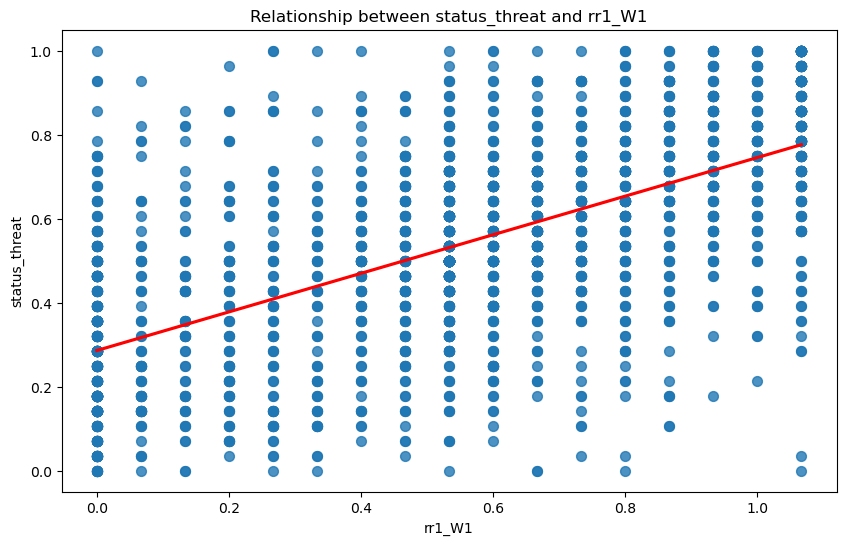

In [127]:
# Example usage
proxy_col = 'rr1_W1'
status_threat_col = 'status_threat' 

proxy_visualize(df2, proxy_col, status_threat_col)


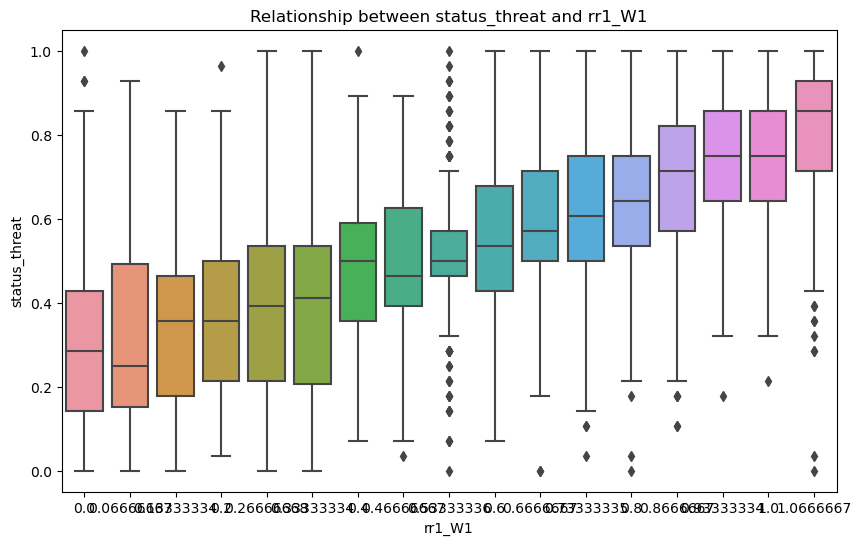

In [128]:
# Example usage
proxy_col = 'rr1_W1'
status_threat_col = 'status_threat'  # Replace with the actual column name for status threat

plot_categorical_vs_status_threat(df2, proxy_col, status_threat_col)

In [12]:
# TEST CASE 1: NO ORTHOGONALIZATION

# specific item we'd like to make a proxy for
item = 'status_threat' 

# specific variables we use to predict the item in first dataframe
predictors = [
                   'psc1_W1_01',
                   'christian_nationalism',
                   'authoritarianism',
                   'social_dom11',
                   'race_resent',
                   'party_ID',
                   'ideology',
                   'age501',
                   'education'] 



# .dta file with item measure
datafile_item = r'C:\Users\kirin\Downloads\W1_W2_W3_Merged_saved.dta'

# .dta file we want to find a proxy in
datafile_proxy = r'C:\Users\kirin\Downloads\W1_W2_W3_Merged_saved.dta'


df1 = pd.read_stata(datafile_item)
df2 = pd.read_stata(datafile_proxy, convert_categoricals=False)

# find and print suggested proxy
best_proxies = proxy_finder(df1, df2, item, predictors, num_proxies = 10)


C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p_value': model.pvalues[1],  # p-value for the proxy
C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'coef': model.params[1]
C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p_value': model.pv

No valid data for candidate weight3_W3


C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p_value': model.pvalues[1],  # p-value for the proxy
C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'coef': model.params[1]
C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p_value': model.pv

No valid data for candidate weight3_W2


C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p_value': model.pvalues[1],  # p-value for the proxy
C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'coef': model.params[1]
C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p_value': model.pv


suggested proxies:
Proxy 1 for status_threat: rr1_W1 with R_squared: 0.739542167566921 and p_value: 0.0
Proxy 2 for status_threat: rr_W1 with R_squared: 0.739542167538694 and p_value: 0.0
Proxy 3 for status_threat: rrx_W1 with R_squared: 0.739542167538694 and p_value: 0.0
Proxy 4 for status_threat: race_resent with R_squared: 0.739542167538694 and p_value: 0.0
Proxy 5 for status_threat: ideo7 with R_squared: 0.6777995342502088 and p_value: 6.33208764113e-312
Proxy 6 for status_threat: ideology with R_squared: 0.6777995336025397 and p_value: 6.332095656673e-312
Proxy 7 for status_threat: cn1_W2 with R_squared: 0.6655164425490327 and p_value: 1.0814553757761965e-301
Proxy 8 for status_threat: christian_nationalism with R_squared: 0.6655164425490327 and p_value: 1.0814553757761965e-301
Proxy 9 for status_threat: cn_W2 with R_squared: 0.6655164404829186 and p_value: 1.0814595826331921e-301
Proxy 10 for status_threat: presvote24 with R_squared: 0.6219309974910201 and p_value: 1.14746832813

C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p_value': model.pvalues[1],  # p-value for the proxy
C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'coef': model.params[1]
C:\Users\kirin\AppData\Local\Temp\ipykernel_8912\1185460691.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p_value': model.pv

In [147]:
# TEST CASE 2: ORTHOGONALIZATION

# specific item we'd like to make a proxy for
item = 'status_threat' 

# specific variables we use to predict the item in first dataframe
predictors = [
                   'psc1_W1_01',
                   'christian_nationalism',
                   'authoritarianism',
                   'social_dom11',
                   'race_resent',
                   'party_ID',
                   'ideology',
                   'age501',
                   'education'] 

# variables we'd like to remove the influence of on predicted item
orthogonal_vars = ['christian_nationalism', 
                   'authoritarianism', 
                   'social_dom11', 
                   'race_resent', 
                   'party_ID', 
                   'ideology']


# .dta file with item measure
datafile_item = r'C:\Users\kirin\Downloads\W1_W2_W3_Merged_saved.dta'

# .dta file we want to find a proxy in
datafile_proxy = r'C:\Users\kirin\Downloads\W1_W2_W3_Merged_saved.dta'


df1 = pd.read_stata(datafile_item)
df2 = pd.read_stata(datafile_proxy, convert_categoricals=False)

# find and print suggested proxy
best_proxies = proxy_finder(df1, df2, item, predictors, num_proxies = 5, orthogonal_vars=orthogonal_vars)

Input Error: Predictors cannot predict item in df1
Aborting program


SystemExit: -1

C:\Users\kirin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [118]:
# test 2.2:
# Confirm orthogonality
check_orthogonality(orthogonal_vars, df2, best_proxies[0])

MissingDataError: exog contains inf or nans